# RNN for japanese character classification

499 4.99 1.5403 data/train\a__44364.csv / a CORRECT
999 9.99 1.5057 data/train\a__29661.csv / a CORRECT
1499 14.99 1.4974 data/train\e__26726.csv / e CORRECT
1999 19.99 1.6011 data/train\i__70302.csv / e WRONG (i)
2499 24.990000000000002 1.6155 data/train\i__28157.csv / u WRONG (i)
2999 29.99 1.6020 data/train\i__92051.csv / u WRONG (i)
3499 34.99 1.5494 data/train\a__85026.csv / e WRONG (a)
3999 39.989999999999995 1.3723 data/train\e__54428.csv / e CORRECT
4499 44.99 1.2324 data/train\o__48681.csv / o CORRECT
4999 49.99 2.0506 data/train\i__54477.csv / u WRONG (i)
5499 54.99000000000001 1.8401 data/train\a__44364.csv / u WRONG (a)
5999 59.99 1.4609 data/train\i__70302.csv / a WRONG (i)
6499 64.99000000000001 1.3690 data/train\i__12320.csv / u WRONG (i)
6999 69.99 0.0122 data/train\e__54428.csv / e CORRECT
7499 74.99 1.3285 data/train\a__55117.csv / i WRONG (a)
7999 79.99000000000001 1.7938 data/train\o__42940.csv / a WRONG (o)
8499 84.99 1.4745 data/train\u__06655.csv / u CORRECT
8999

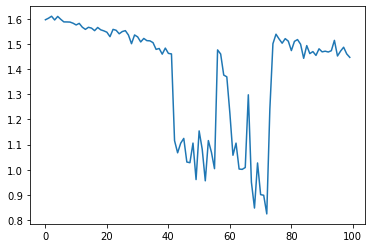

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

from utils import load_data, file_to_tensor, character_to_tensor, random_training_example

class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)
    
character_files, all_characters = load_data()
n_characters = len(all_characters)

n_features = 3 # x,y,z
n_hidden = 128


rnn = RNN(n_features, n_hidden, n_characters)


def character_from_output(output):
    character_idx = torch.argmax(output).item()
    return all_characters[character_idx]

criterion = nn.NLLLoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(file_tensor, character_tensor):
    hidden = rnn.init_hidden()
    
    # über seq-lenght iterieren
    for i in range(file_tensor.size()[0]):
        output, hidden = rnn(file_tensor[i], hidden)
        
    loss = criterion(output, character_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

current_loss = 0
all_losses = []

plot_steps, print_steps = 100, 500
n_iters = 10000

for i in range(n_iters):
    character, file, character_tensor, file_tensor = random_training_example(character_files, all_characters)
    output, loss = train(file_tensor, character_tensor)
    current_loss += loss
    
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        guess = character_from_output(output)
        correct = "CORRECT" if guess == character else f"WRONG ({character})"
        print(f"{i} {i/n_iters*100} {loss:.4f} {file} / {guess} {correct}")
        
plt.figure()
plt.plot(all_losses)
plt.show()